In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')

import data_preprocessing
import context_handlers
import vit_pipeline


############################################################################################################
##################################################vit_l_16##################################################
############################################################################################################


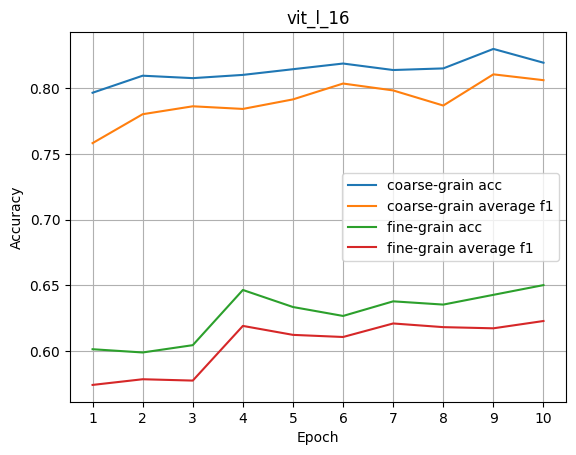

<Figure size 640x480 with 0 Axes>

In [2]:
results_dir = 'results/'

test_data = {}
test_fine_true = np.load(os.path.join(results_dir, f'test_fine_true.npy'))
test_coarse_true = np.load(os.path.join(results_dir, f'test_coarse_true.npy'))

for filename in os.listdir(results_dir):
    test_match = re.match(pattern=rf'(.+?)_test_(.+?)_pred_lr(.+?)_e(\d+?).npy',
                               string=filename)
    if test_match:
        model_name = test_match.group(1)
        granularity = test_match.group(2)
        lr_value = float(test_match.group(3))
        num_epochs = int(test_match.group(4)) + 1
    
        test_pred = np.load(os.path.join(results_dir, filename))
        classes = data_preprocessing.get_classes(granularity=granularity)
        n_classes = len(classes)
        test_true = test_fine_true if granularity == 'fine' else test_coarse_true
    
        if model_name not in test_data:
            test_data[model_name] = {}
        if granularity not in test_data[model_name]:
            test_data[model_name][granularity] = {}
        if lr_value not in test_data[model_name][granularity]:
            test_data[model_name][granularity][lr_value] = {}
    
        test_data[model_name][granularity][lr_value][num_epochs] = \
            {'acc': accuracy_score(y_true=test_true, y_pred=test_pred), 
             'cm': confusion_matrix(y_true=test_true, y_pred=test_pred),
             'pre': precision_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro'),
             'rec': recall_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro'),
             'f1': f1_score(y_true=test_true, y_pred=test_pred, labels=range(n_classes), average='macro')}
                
def plot_verbose_test_metrics():
    for model_name, model_data in sorted(test_data.items()):
        print('\n' + '#'* (100 + len(model_name)))
        print('#'* 50 + f'{model_name}' + '#'* 50)
        print('#'* (100 + len(model_name)) + '\n')
        metric = 'Accuracy'
        
        with context_handlers.Plot():
            plt.title(f"{model_name}")
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            
            for granularity, granularity_data in sorted(model_data.items()):
                for lr_value, lr_data in sorted(granularity_data.items()):
                    epochs, epoch_data = zip(*sorted(lr_data.items()))
                    plt.plot(epochs, [curr_data['acc'] for curr_data in epoch_data], label=f'{granularity}-grain acc')
                    plt.plot(epochs, [curr_data['f1'] for curr_data in epoch_data], label=f'{granularity}-grain average f1')
                    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1)) # Set the x-axis ticks to be integers
        
            plt.legend()
            plt.grid()

plot_verbose_test_metrics()

# Inconsistencies

In [10]:
main_model_name = 'vit_l_16'
main_lr = 0.0001
secondary_model_name = 'vit_l_16'
secondary_lr = 0.0001

main_model_fine_path = f'{main_model_name}_test_fine_pred_lr{main_lr}_e{vit_pipeline.num_epochs - 1}.npy'
main_model_coarse_path = f'{main_model_name}_test_coarse_pred_lr{main_lr}_e{vit_pipeline.num_epochs - 1}.npy'

secondary_model_fine_path = (f'{secondary_model_name}_test_fine_pred_lr{secondary_lr}'
                             f'_e{vit_pipeline.num_epochs - 1}_2.npy')
secondary_model_coarse_path = (f'{secondary_model_name}_test_coarse_pred_lr{secondary_lr}'
                               f'_e{vit_pipeline.num_epochs - 1}_2.npy')

main_fine_data = np.load(os.path.join(vit_pipeline.results_path, main_model_fine_path))
main_coarse_data = np.load(os.path.join(vit_pipeline.results_path, main_model_coarse_path))

secondary_fine_data = np.load(os.path.join(vit_pipeline.results_path, secondary_model_fine_path))
secondary_coarse_data = np.load(os.path.join(vit_pipeline.results_path, secondary_model_coarse_path))

true_fine_data = np.load(os.path.join(vit_pipeline.results_path, 'test_fine_true.npy'))
true_coarse_data = np.load(os.path.join(vit_pipeline.results_path, 'test_coarse_true.npy'))

main_prior_fine_acc = accuracy_score(y_true=true_fine_data, y_pred=main_fine_data)
main_prior_coarse_acc = accuracy_score(y_true=true_coarse_data, y_pred=main_coarse_data)

secondary_prior_fine_acc = accuracy_score(y_true=true_fine_data, y_pred=secondary_fine_data)
secondary_prior_coarse_acc = accuracy_score(y_true=true_coarse_data, y_pred=secondary_coarse_data)
    
print(f'Main prior fine accuracy: {round(main_prior_fine_acc * 100, 2)}%, '
          f'main prior coarse accuracy: {round(main_prior_coarse_acc * 100, 2)}%\n'
          f'Secondary prior fine accuracy: {round(secondary_prior_fine_acc * 100, 2)}%, '
          f'secondary prior coarse accuracy: {round(secondary_prior_coarse_acc * 100, 2)}%\n')

inconsistencies = 0
for fine_prediction, coarse_prediction in zip(main_fine_data, main_coarse_data):
    if data_preprocessing.fine_to_course_idx[fine_prediction] != coarse_prediction:
        inconsistencies += 1

print(f'Total prior inconsistencies {inconsistencies}/{len(main_fine_data)} which is {round(inconsistencies / len(main_fine_data) * 100, 2)}%')

Main prior fine accuracy: 65.02%, main prior coarse accuracy: 81.92%
Secondary prior fine accuracy: 61.44%, secondary prior coarse accuracy: 79.46%

Total prior inconsistencies 82/1621 which is 5.06%


# EDCR Results

In [3]:
best_coarse_main_model = 'vit_l_16'
best_coarse_main_lr = '1e-06'
best_coarse_secondary_model = 'vit_b_16'
best_coarse_secondary_lr = '5e-05'
best_coarse_folder = f'main_coarse_{best_coarse_main_model}_lr{best_coarse_main_lr}_secondary_{best_coarse_secondary_model}_lr{best_coarse_secondary_lr}'
best_coarse_results = np.load(rf'{EDCR_pipeline.figs_folder}{best_coarse_folder}/results.npy')
coarse_test_true = np.load(os.path.join(EDCR_pipeline.data_folder, f'test_true_coarse.npy'))

best_fine_main_model = 'vit_l_16'
best_fine_main_lr = '1e-06'
best_fine_secondary_model = 'vit_b_16'
best_fine_secondary_lr = '1e-06'
best_fine_folder = f'main_fine_{best_fine_main_model}_lr{best_fine_main_lr}_secondary_{best_fine_secondary_model}_lr{best_fine_secondary_lr}'
best_fine_results = np.load(rf'{EDCR_pipeline.figs_folder}{best_fine_folder}/results.npy')
fine_test_true = np.load(os.path.join(EDCR_pipeline.data_folder, f'test_true.npy'))

with open('fine_to_coarse.json', 'r') as json_file:
    image_fine_to_coarse = json.load(json_file)

image_fine_to_coarse = {int(fine): int(coarse) for batch_dict in image_fine_to_coarse for fine, coarse in batch_dict.items()}
image_fine_to_coarse

# def get_num_of_inconsistencies(coarse_results: np.array, 
#                                fine_results: np.array) -> int:
#     num_of_inconsistencies = 0
#     for fine_example_num, fine_prediction_index in enumerate(fine_results):
#         coarse_example_num = image_fine_to_coarse[fine_example_num]
#         coarse_prediction_index = coarse_results[coarse_example_num]
#         
#         fine_prediction = EDCR_pipeline.get_classes(granularity='fine')[fine_prediction_index]
#         coarse_prediction = EDCR_pipeline.get_classes(granularity='coarse')[coarse_prediction_index]
#         derived_coarse_prediction = EDCR_pipeline.fine_to_coarse[fine_prediction]
# 
#         if derived_coarse_prediction != coarse_prediction:
#             num_of_inconsistencies += 1
# 
#     return num_of_inconsistencies
# 
# get_num_of_inconsistencies(coarse_results=coarse_test_true,
#                            fine_results=fine_test_true)

{0: 1032,
 1: 1030,
 2: 990,
 3: 989,
 4: 986,
 5: 987,
 6: 980,
 7: 983,
 8: 985,
 9: 984,
 10: 1004,
 11: 1009,
 12: 1022,
 13: 995,
 14: 992,
 15: 997,
 16: 998,
 17: 1005,
 18: 1008,
 19: 1002,
 20: 1001,
 21: 981,
 22: 982,
 23: 1026,
 24: 1006,
 25: 1007,
 26: 1003,
 27: 1000,
 28: 994,
 29: 993,
 30: 996,
 31: 999,
 32: 991,
 33: 988,
 34: 1011,
 35: 1019,
 36: 1018,
 37: 1010,
 38: 1015,
 39: 1024,
 40: 1025,
 41: 1033,
 42: 1028,
 43: 975,
 44: 976,
 45: 1013,
 46: 1023,
 47: 1027,
 48: 1031,
 49: 1029,
 50: 1020,
 51: 1016,
 52: 1012,
 53: 1014,
 54: 977,
 55: 1021,
 56: 1017,
 57: 978,
 58: 979,
 59: 133,
 60: 132,
 61: 122,
 62: 121,
 63: 119,
 64: 120,
 65: 115,
 66: 116,
 67: 118,
 68: 117,
 69: 124,
 70: 125,
 71: 130,
 72: 123,
 73: 131,
 74: 126,
 75: 127,
 76: 129,
 77: 128,
 78: 113,
 79: 114,
 80: 1202,
 81: 1196,
 82: 1120,
 83: 1096,
 84: 1093,
 85: 1102,
 86: 1103,
 87: 1114,
 88: 1119,
 89: 1109,
 90: 1108,
 91: 1124,
 92: 1129,
 93: 1113,
 94: 1115,
 95: 1118,


In [9]:
best_coarse_main_model = 'vit_l_16'
best_coarse_main_lr = '1e-06'
best_coarse_secondary_model = 'vit_b_16'
best_coarse_secondary_lr = '5e-05'

folder = (f'{EDCR_pipeline.figs_folder}/main_coarse_{best_coarse_main_model}_lr{best_coarse_main_lr}'
                  f'_secondary_{best_coarse_secondary_model}_lr{best_coarse_secondary_lr}')

with open(f'{folder}/error_detections.json', 'r') as json_file:
    error_detections = json.load(json_file)

print('Error detections:\n')
for coarse_grain_label, coarse_grain_label_data in error_detections.items():
    for fine_grain_label in coarse_grain_label_data.keys():
        print(f'error <- predicted_coarse_grain = {coarse_grain_label} '
              f'and predicted_fine_grain = {fine_grain_label}')

Error detections:

error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = T-14
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BMP-T15
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BTR-80
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = MT_LB
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BTR-70
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = T-90
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = T-62
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BTR-60
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = TOS-1
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = D-30
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BRDM
error <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BMD
error <- predicted_coarse_grain = A

In [14]:
with open(f'{folder}/corrections.json', 'r') as json_file:
    corrections = json.load(json_file)

print('Corrections:\n')
for coarse_grain_label, coarse_grain_label_data in corrections.items():
    for fine_grain_label in coarse_grain_label_data.keys():
        print(f'correct_coarse_grain = {EDCR_pipeline.fine_to_coarse[fine_grain_label]} <- predicted_coarse_grain = {coarse_grain_label} '
              f'and predicted_fine_grain = {fine_grain_label}')

Corrections:

correct_coarse_grain = Self Propelled Artillery <- predicted_coarse_grain = Air Defense and predicted_fine_grain = BM-30
correct_coarse_grain = BTR <- predicted_coarse_grain = BMP and predicted_fine_grain = BRDM
correct_coarse_grain = BMP <- predicted_coarse_grain = BMP and predicted_fine_grain = BMP-T15
correct_coarse_grain = BTR <- predicted_coarse_grain = BTR and predicted_fine_grain = BTR-60
correct_coarse_grain = BTR <- predicted_coarse_grain = BTR and predicted_fine_grain = BTR-70
correct_coarse_grain = BTR <- predicted_coarse_grain = BTR and predicted_fine_grain = BTR-80
correct_coarse_grain = Air Defense <- predicted_coarse_grain = Self Propelled Artillery and predicted_fine_grain = Rs-24
correct_coarse_grain = Air Defense <- predicted_coarse_grain = Self Propelled Artillery and predicted_fine_grain = Pantsir-S1
correct_coarse_grain = Tank <- predicted_coarse_grain = Tank and predicted_fine_grain = T-72
correct_coarse_grain = Tank <- predicted_coarse_grain = Tank 